In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('retail_sales_data.csv')

In [3]:
df.head()

,DATE,MRTSSM448USN
0,1992-01-01,6938
1,1992-02-01,7524
2,1992-03-01,8475
3,1992-04-01,9401
4,1992-05-01,9558


In [4]:
df = pd.read_csv('retail_sales_data.csv', parse_dates=True, index_col='DATE')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 351 entries, 1992-01-01 to 2021-03-01
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   MRTSSM448USN  351 non-null    int64
dtypes: int64(1)
memory usage: 5.5 KB


In [6]:
df.columns = ['Sales']

In [7]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


<AxesSubplot:xlabel='DATE'>

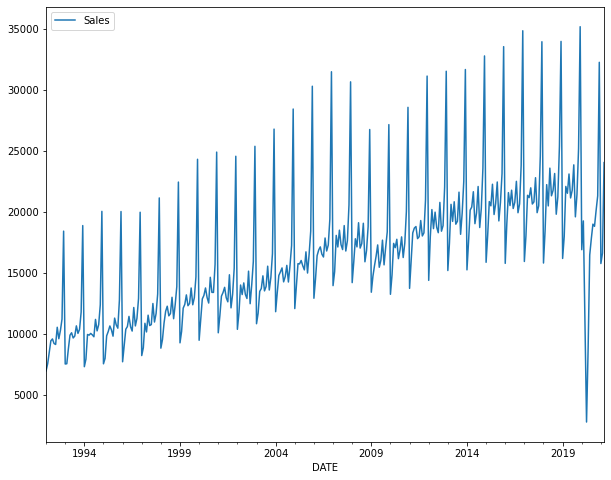

In [8]:
df.plot(figsize=(10,8))

In [9]:
len(df) - 18 #1.5 year = 18 months

333

In [10]:
test_size = 18
test_index = len(df) - test_size

In [11]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

### Scaling Data

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
scaler.fit(train)

MinMaxScaler()

In [15]:
scaled_train = scaler.transform(train)

scaled_test = scaler.transform(test)

In [16]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
length = 12 #should be less than test set size which is 18 here

In [18]:
generator = TimeseriesGenerator(scaled_train, scaled_train, length = length, batch_size=1)

In [19]:
X,y = generator[0]

In [20]:
X

array([[[0.        ],
        [0.02101413],
        [0.05511726],
        [0.08832389],
        [0.09395396],
        [0.08047049],
        [0.07763752],
        [0.12820053],
        [0.09449186],
        [0.11891272],
        [0.15237037],
        [0.41085132]]])

In [21]:
y

array([[0.0202252]])

In [22]:
len(X[0])

12

In [23]:
from tensorflow.keras.models import Sequential

In [24]:
from tensorflow.keras.layers import Dense, LSTM

In [25]:
n_features = 1

In [26]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [28]:
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [30]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length = length, batch_size=1)

In [31]:
model.fit(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20
321/321 [==============================] - 2s 4ms/step - loss: 0.0270 - val_loss: 0.0492
Epoch 2/20
321/321 [==============================] - 1s 3ms/step - loss: 0.0153 - val_loss: 0.0260
Epoch 3/20
321/321 [==============================] - 1s 3ms/step - loss: 0.0083 - val_loss: 0.0267
Epoch 4/20
321/321 [==============================] - 1s 3ms/step - loss: 0.0036 - val_loss: 0.0275


In [33]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

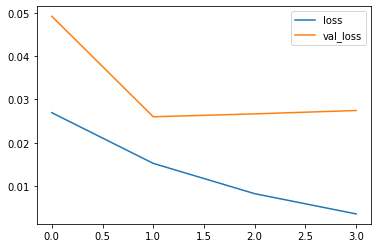

In [34]:
losses.plot()

In [35]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
  
    test_predictions.append(current_pred)
  
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [36]:
true_predictions = scaler.inverse_transform(test_predictions)

In [37]:
test['Predictions'] = true_predictions

<ipython-input-37-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [38]:
test

,Sales,Predictions
DATE,,
2019-10-01,21400,22279.173107
2019-11-01,25170,26065.156237
2019-12-01,35157,36646.910131
2020-01-01,16873,18159.339334
2020-02-01,19232,19643.372524
2020-03-01,10969,22812.261395
2020-04-01,2744,22455.698506
2020-05-01,8787,23826.376574
2020-06-01,16442,22251.470301


<AxesSubplot:xlabel='DATE'>

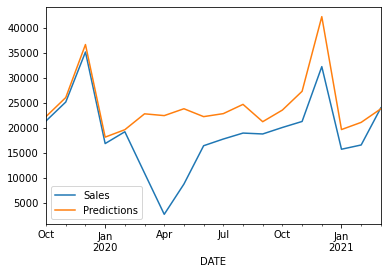

In [39]:
test.plot()